In [31]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy import stats
from itertools import combinations
import networkx as nx
from statsmodels.tsa import stattools as sm
warnings.filterwarnings("ignore")
cryptos = ['ADA', 'AE', 'BCH', 'BCN', 'BNB', 'BTC', 'BTS',
          'DASH', 'DCR', 'EOS', 'ETC', 'ETH', 'ICX', 'LSK', 'LTC',
          'MKR', 'NANO', 'NEO', 'OMG', 'ONT', 'QTUM', 'REP', 'RHOC',
          'SC', 'STEEM', 'TRX', 'USDT', 'VEN', 'WAN', 'WAVES', 'XEM',
          'XLM', 'XMR', 'XRP', 'XVG', 'ZEC', 'ZIL', 'ZRX']
combinations = list( combinations(cryptos, 2) )
p_5 = 0.05/len(combinations)
p_1 = 0.01/len(combinations)

In [2]:
def ccdf(data):
    """
    Plot the complementary cumulative distribution function
    (1-CDF(x)) based on the data on the axes object.
    Note that this way of computing and plotting the ccdf is not
    the best approach for a discrete variable, where many
    observations can have exactly same value!
    """
    # Note that, here we use the convention for presenting an
    # empirical 1-CDF (ccdf) as discussed
    # a quick way of computing a ccdf (valid for continuous data):
    sorted_vals = np.sort(np.unique(data))
    ccdf = np.zeros(len(sorted_vals))
    n = float(len(data))
    for i, val in enumerate(sorted_vals):
        ccdf[i] = np.sum(data >= val)/n
    return sorted_vals, ccdf

log-price data:

In [3]:
prices = []
for i in range(len(cryptos)):
    df = pd.read_csv('/Users/julienraffaud/Desktop/Financial Data & Statistics/'+str(cryptos[i])+'_merged.txt')
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.set_index('time')
    df = df[[df.columns[1], df.columns[2], df.columns[10]]]
    df['close'] = np.log(df.close) - np.log(df.close.shift(1))
    prices.append(pd.DataFrame(df['close']))
prices = pd.concat(prices, axis=1).dropna()
prices.columns = cryptos

log-positive sentiment data:

In [4]:
pos = []
for i in range(len(cryptos)):
    df = pd.read_csv('/Users/julienraffaud/Desktop/Financial Data & Statistics/'+str(cryptos[i])+'_merged.txt')
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.set_index('time')
    df = df[[df.columns[1], df.columns[2], df.columns[10]]]
    df['close'] = np.log(df.close) - np.log(df.close.shift(1))
    df['pos'] = np.log(df.positive_score_en) - np.log(df.positive_score_en.shift(1))
    pos.append(pd.DataFrame(df['pos']))
pos = pd.concat(pos, axis=1).dropna()
pos.columns = cryptos

log-negative sentiment data:

In [5]:
neg = []
for i in range(len(cryptos)):
    df = pd.read_csv('/Users/julienraffaud/Desktop/Financial Data & Statistics/'+str(cryptos[i])+'_merged.txt')
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.set_index('time')
    df = df[[df.columns[1], df.columns[2], df.columns[10]]]
    df['close'] = np.log(df.close) - np.log(df.close.shift(1))
    df['neg'] = np.log(df.negative_score_en) - np.log(df.negative_score_en.shift(1))
    neg.append(pd.DataFrame(df['neg']))
neg = pd.concat(neg, axis=1).dropna()
neg.columns = cryptos

0.4399457216751993


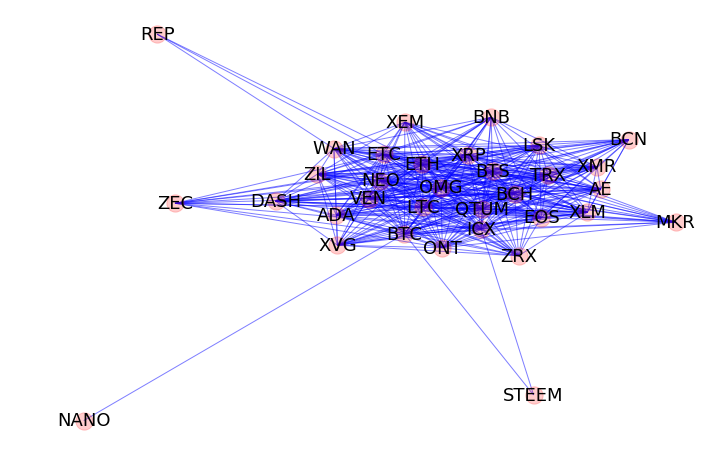

In [6]:
plt.figure(figsize=(12, 8))
kendalls = []
price_pairs = []
for pair in combinations:
        kendall, pv = stats.kendalltau(prices[pair[0]], prices[pair[1]], nan_policy='omit')
        if pv<p_1/10000000000000000:
            price_tuple = (pair[0], pair[1], kendall)
            price_pairs.append(price_tuple)
            kendalls.append(kendall)
P=nx.Graph()
P.add_weighted_edges_from(price_pairs)
elarge = [(u, v) for (u, v, d) in P.edges(data=True) if abs(d['weight']) > abs(np.mean(kendalls))]
esmall = [(u, v) for (u, v, d) in P.edges(data=True) if abs(d['weight']) <= abs(np.mean(kendalls))]
epos = [(u, v) for (u, v, d) in P.edges(data=True) if d['weight'] > 0]
eneg = [(u, v) for (u, v, d) in P.edges(data=True) if d['weight'] < 0]

post = nx.spring_layout(P)  # positions for all nodes
nx.draw_networkx_nodes(P, post, labels=price_pairs, alpha=0.2)
nx.draw_networkx_edges(P, post, edgelist=elarge,
                       width=1, alpha=0.5, edge_color='blue')
nx.draw_networkx_edges(P, post, edgelist=esmall,
                        width=1, alpha=0.5, edge_color='blue')
nx.draw_networkx_edges(P, post, edgelist=eneg,
                        edge_color='red')
nx.draw_networkx_labels(P, post, font_color='black', font_size=18, font_family='Sawasdee')
plt.axis('off')
plt.savefig('prices', quality=95)
print(np.median(kendalls))

0.1658497430296946


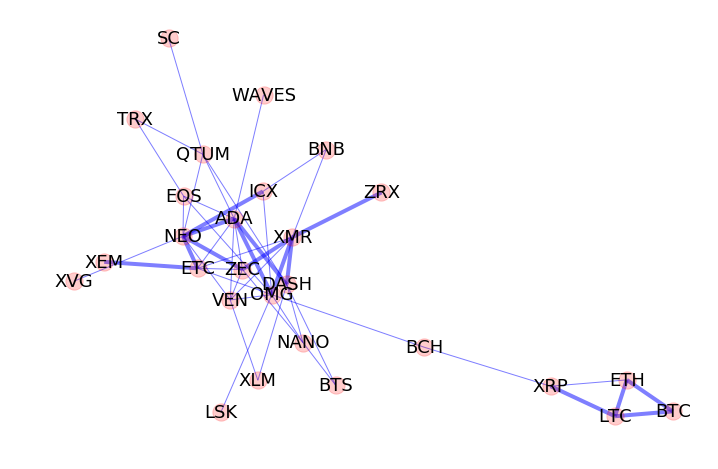

In [7]:
plt.figure(figsize=(12, 8))
kendalls = []
pos_pairs = []
for pair in combinations:
        kendall, pv = stats.kendalltau(pos[pair[0]], pos[pair[1]], nan_policy='omit')
        if pv<p_5:
            pos_tuple = (pair[0], pair[1], kendall)
            pos_pairs.append(pos_tuple)
            kendalls.append(kendall)
M=nx.Graph()
M.add_weighted_edges_from(pos_pairs)
elarge = [(u, v) for (u, v, d) in M.edges(data=True) if abs(d['weight']) > abs(np.mean(kendalls))]
esmall = [(u, v) for (u, v, d) in M.edges(data=True) if abs(d['weight']) <= abs(np.mean(kendalls))]
epos = [(u, v) for (u, v, d) in M.edges(data=True) if d['weight'] > 0]
eneg = [(u, v) for (u, v, d) in M.edges(data=True) if d['weight'] < 0]

post = nx.spring_layout(M)  # positions for all nodes
nx.draw_networkx_nodes(M, post, labels=price_pairs, alpha=0.2)
nx.draw_networkx_edges(M, post, edgelist=elarge,
                       width=4, alpha=0.5, edge_color='blue')
nx.draw_networkx_edges(M, post, edgelist=esmall,
                        width=1, alpha=0.5, edge_color='blue')
nx.draw_networkx_edges(M, post, edgelist=eneg,
                        edge_color='red')
nx.draw_networkx_labels(M, post, font_color='black', font_size=18, font_family='Sawasdee')
plt.axis('off')
plt.savefig('positive', quality=95)
print(np.median(kendalls))

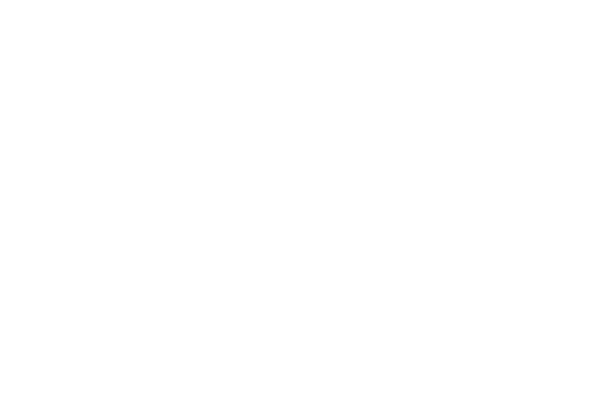

In [18]:
plt.figure(figsize=(10,7))
kendalls = []
neg_pairs = []
for pair in combinations:
        kendall, pv = stats.kendalltau(neg[pair[0]], neg[pair[1]], nan_policy='omit')
        if pv<p_5:
            neg_tuple = (pair[0], pair[1], kendall)
            neg_pairs.append(neg_tuple)
            kendalls.append(kendall)
G=nx.Graph()
G.add_weighted_edges_from(neg_pairs)
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if abs(d['weight']) > abs(np.mean(kendalls))]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if abs(d['weight']) <= abs(np.mean(kendalls))]
epos = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0]
eneg = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] < 0]

post = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, post, labels=price_pairs, alpha=0.2)
nx.draw_networkx_edges(G, post, edgelist=elarge,
                       width=3, alpha=0.5, edge_color='blue')
nx.draw_networkx_edges(G, post, edgelist=esmall,
                        width=1, alpha=0.5, edge_color='blue')
nx.draw_networkx_edges(G, post, edgelist=eneg,
                        edge_color='red', alpha=1)
nx.draw_networkx_labels(G, post, font_color='black', font_size=18)
plt.axis('off')
plt.savefig('nada', quality=95)

5.0

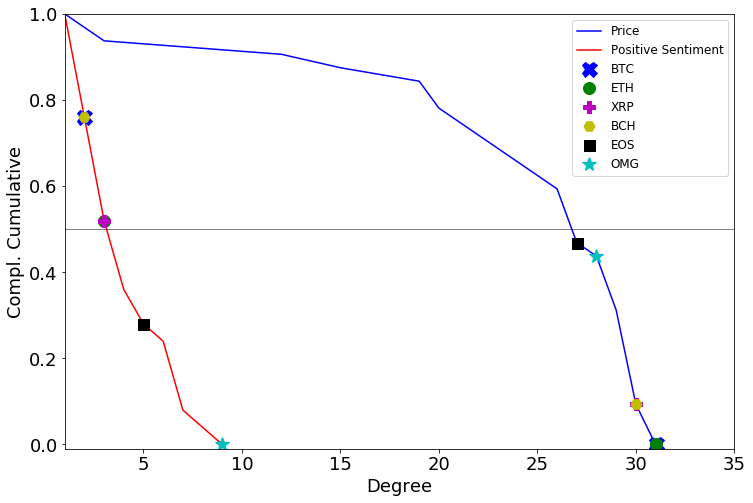

In [30]:
plt.figure(figsize=(12,8))
p_srtd, p_cc = ccdf([d for n, d in P.degree()])

p_cc = (p_cc-min(p_cc))/(max(p_cc)-min(p_cc))

plt.plot(p_srtd, p_cc, '-', color='b')

srtd, cc = ccdf([d for n, d in M.degree()])
cc = (cc-min(cc))/(max(cc)-min(cc))
plt.plot(srtd, cc, '-', color='r')

plt.plot(p_srtd[-1], p_cc[-1], 'X', color='b', markersize=15)
plt.plot(p_srtd[-1], p_cc[-1], 'o', color='g', markersize=12)
plt.plot(p_srtd[-2], p_cc[-2], 'P', color='m', markersize=12)
plt.plot(p_srtd[-2], p_cc[-2], 'H', color='y', markersize=11)
plt.plot(p_srtd[-5], p_cc[-5], 's', color='k', markersize=11)
plt.plot(p_srtd[-4], p_cc[-4], '*', color='c', markersize=15)
plt.plot(9, 0, '*', color='c', markersize=15)
plt.legend(['Price', 'Positive Sentiment', 'BTC', 'ETH', 'XRP', 'BCH', 'EOS', 'OMG'], fontsize=12, loc=1)

plt.plot(srtd[1], cc[1], 'X',  color='b', markersize=15)
plt.plot(srtd[2], cc[2], 'o',  color='g', markersize=12)
plt.plot(srtd[2], cc[2], 'P', color='m', markersize=12)
plt.plot(srtd[1], cc[1], 'H', color='y', markersize=11)
plt.plot(srtd[4], cc[4], 's',  color='k', markersize=11)
plt.ylim([-0.01, 1.0])

plt.xlim([1, 35])
csfont = {'fontname':'Times New Roman'}
plt.xlabel('Degree', fontsize=18)
plt.ylabel('Compl. Cumulative', fontsize=18)
plt.plot(range(0, 43), [0.5 for i in range(0, 43)], 'k', linewidth=0.5)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('degrees', quality=95)
np.mean( srtd )

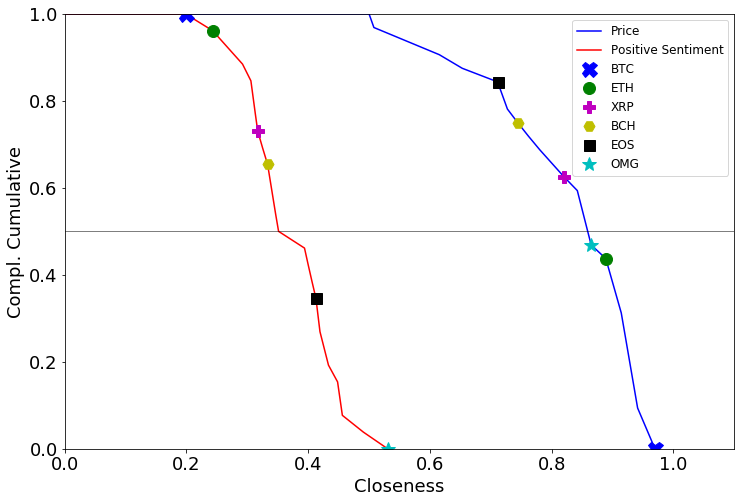

In [20]:
plt.figure(figsize=(12,8))

p_srtd, p_cc = ccdf(list(nx.algorithms.centrality.closeness_centrality(P).values()))
p_cc = (p_cc - min(p_cc))/(max(p_cc)-min(p_cc))

srtd, cc = ccdf(list(nx.algorithms.centrality.closeness_centrality(M).values()))
cc = (cc - min(cc))/(max(cc)-min(cc))

srtd = np.hstack((0, srtd))
cc = np.hstack((1, cc))
p_srtd = np.hstack((0, p_srtd))
p_cc = np.hstack((1, p_cc))

plt.plot(p_srtd, p_cc, '-', color='b')
plt.plot(srtd, cc, '-', color='r')

plt.plot(p_srtd[-1], p_cc[-1], 'X', color='b', markersize=15)
plt.plot(p_srtd[-4], p_cc[-4], 'o', color='g', markersize=12)
plt.plot(p_srtd[-7], p_cc[-7], 'P', color='m', markersize=12)
plt.plot(p_srtd[-10], p_cc[-10], 'H', color='y', markersize=11)
plt.plot(p_srtd[-12], p_cc[-12], 's', color='k', markersize=11)
plt.plot(p_srtd[-5], p_cc[-5], '*', color='c', markersize=15)

plt.legend(['Price', 'Positive Sentiment', 'BTC', 'ETH', 'XRP', 'BCH', 'EOS', 'OMG'], fontsize=12, loc=1)

plt.plot(srtd[1], cc[1], 'X', color='b', markersize=15)
plt.plot(srtd[2], cc[2], 'o', color='g', markersize=12)
plt.plot(srtd[6], cc[6], 'P', color='m', markersize=12)
plt.plot(srtd[-13], cc[-13], 'H', color='y', markersize=11)
plt.plot(srtd[-7], cc[-7], 's', color='k', markersize=11)
plt.plot(srtd[-1], cc[-1], '*', color='c', markersize=15)


plt.plot(range(0, 43), [0.5 for i in range(0, 43)], 'k', linewidth=0.5)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('Closeness', fontsize=18)
plt.ylabel('Compl. Cumulative', fontsize=18)

plt.xlim([0 ,1.1])
plt.ylim([0 ,1.])
plt.savefig('closeness', quality=95)

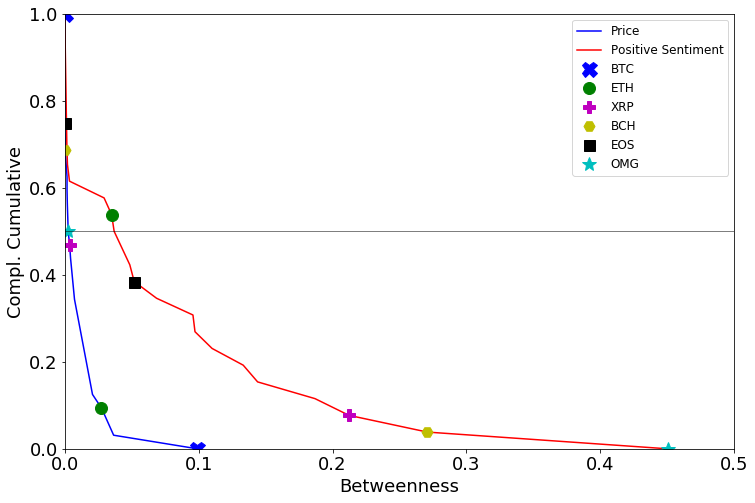

In [21]:
plt.figure(figsize=(12,8))
p_srtd, p_cc = ccdf(list(nx.algorithms.centrality.betweenness_centrality(P).values()))
p_cc = (p_cc - min(p_cc))/(max(p_cc)-min(p_cc))
srtd, cc = ccdf(list(nx.algorithms.centrality.betweenness_centrality(M).values()))
cc = (cc - min(cc))/(max(cc)-min(cc))
srtd = np.hstack((0, srtd))
cc = np.hstack((1, cc))
p_srtd = np.hstack((0, p_srtd))
p_cc = np.hstack((1, p_cc))
plt.plot(p_srtd, p_cc, '-', color='b')
plt.plot(srtd, cc, '-', color='r')

plt.plot(p_srtd[-1], p_cc[-1], 'X', color='b', markersize=15)
plt.plot(p_srtd[-3], p_cc[-3], 'o', color='g', markersize=12)
plt.plot(p_srtd[-7], p_cc[-7], 'P', color='m', markersize=12)
plt.plot(p_srtd[-12], p_cc[-12], 'H', color='y', markersize=11)
plt.plot(p_srtd[-13], p_cc[-13], 's', color='k', markersize=11)
plt.plot(p_srtd[-8], p_cc[-8], '*', color='c', markersize=15)

plt.legend(['Price', 'Positive Sentiment', 'BTC', 'ETH', 'XRP', 'BCH', 'EOS', 'OMG'], fontsize=12, loc=1)

plt.plot(srtd[1], cc[1], 'X', color='b', markersize=15)
plt.plot(srtd[-14], cc[-14], 'o', color='g', markersize=12)
plt.plot(srtd[-3], cc[-3], 'P', color='m', markersize=12)
plt.plot(srtd[-2], cc[-2], 'H', color='y', markersize=11)
plt.plot(srtd[-11], cc[-11], 's', color='k', markersize=11)
plt.plot(srtd[-1], cc[-1], '*', color='c', markersize=15)

plt.plot(range(0, 43), [0.5 for i in range(0, 43)], 'k', linewidth=0.5)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('Betweenness', fontsize=18)
plt.ylabel('Compl. Cumulative', fontsize=18)


plt.xlim([0 ,.5])
plt.ylim([0 ,1.])
plt.savefig('betweenness', quality=95)

In [273]:
cryptos = ['ADA', 'AE', 'BCH', 'BCN', 'BNB', 'BTC', 'BTS',
          'DASH', 'DCR', 'EOS', 'ETC', 'ETH', 'ICX', 'LSK', 'LTC',
          'MKR', 'NANO', 'NEO', 'OMG', 'ONT', 'QTUM', 'REP', 'RHOC',
          'SC', 'STEEM', 'TRX', 'USDT', 'VEN', 'WAN', 'WAVES', 'XEM',
          'XLM', 'XMR', 'XRP', 'XVG', 'ZEC', 'ZIL', 'ZRX']
print(len(cryptos))

38


In [268]:
cryptos = ['LTC', 'RHOC', 'XEM']
from itertools import combinations
combinat = list( combinations(cryptos, 2) )
p_5 = 0.05/len(combinat)
p_1 = 0.01/len(combinat)
prices = []
for i in range(len(cryptos)):
    df = pd.read_csv('/Users/julienraffaud/Desktop/Financial Data & Statistics/'+str(cryptos[i])+'_merged.txt')
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.set_index('time')
    df = df[[df.columns[1], df.columns[2], df.columns[10]]]
    df['close'] = np.log(df.close) - np.log(df.close.shift(1))
    prices.append(pd.DataFrame(df['close']))
prices = pd.concat(prices, axis=1).dropna()
prices.columns = cryptos
pos = []
for i in range(len(cryptos)):
    df = pd.read_csv('/Users/julienraffaud/Desktop/Financial Data & Statistics/'+str(cryptos[i])+'_merged.txt')
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.set_index('time')
    df = df[[df.columns[1], df.columns[2], df.columns[10]]]
    df['close'] = np.log(df.close) - np.log(df.close.shift(1))
    df['pos'] = np.log(df.positive_score_en) - np.log(df.positive_score_en.shift(1))
    pos.append(pd.DataFrame(df['pos']))
pos = pd.concat(pos, axis=1).dropna()
pos.columns = cryptos
neg = []
for i in range(len(cryptos)):
    df = pd.read_csv('/Users/julienraffaud/Desktop/Financial Data & Statistics/'+str(cryptos[i])+'_merged.txt')
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.set_index('time')
    df = df[[df.columns[1], df.columns[2], df.columns[10]]]
    df['close'] = np.log(df.close) - np.log(df.close.shift(1))
    df['neg'] = np.log(df.negative_score_en) - np.log(df.negative_score_en.shift(1))
    neg.append(pd.DataFrame(df['neg']))
neg = pd.concat(neg, axis=1).dropna()
neg.columns = cryptos

In [272]:
hourly_p = []
daily_p = []
for i in cryptos:
    try:
        granger_df = pd.concat([neg[i], prices[i]], axis=1)
        granger_df.columns = ['NEO', 'pos']
        granger_df = granger_df.dropna()
        print(len(granger_df))
        granger = sm.grangercausalitytests(granger_df[['NEO', 'pos']], maxlag=1, addconst=True, verbose=False)
        p_value = granger[1][0]['ssr_ftest'][0]
        hourly_p.append(p_value)
        if p_value < p_5:
            print('hourly')
            print(i)
            print(p_value)
        granger_df =  granger_df.resample(rule='24H', closed='left', label='left').sum()
        granger = sm.grangercausalitytests(granger_df[['NEO', 'pos']], maxlag=1, addconst=True, verbose=False)
        p_value = granger[1][0]['ssr_ftest'][0]
        if p_value < p_5:
            print('daily')
            print(i)
            print(p_value)
        daily_p.append(p_value)
    except Exception:
        pass

3914
3914
3914
